In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# modelling libraries
import category_encoders as ce
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

We'll be scraping data off of Remax's website and building a linear regression model to predict house prices based on 3 given features:

    - House area (in squared meters);
    - Number of bedrooms;
    - Number of toilets.

# Web Scraping with Selenium

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

options = Options()
options.add_experimental_option("detach", True)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

URL = "https://remax.pt/comprar?searchQueryState=%7B%22regionName%22:%22lisboa%22,%22businessType%22:1,%22page%22:1,%22regionID%22:%22%22,%22regionType%22:%22%22,%22sort%22:%7B%22fieldToSort%22:%22PublishDate%22,%22order%22:1%7D,%22mapIsOpen%22:false%7D"
driver.get(URL)

listings_data = []

while True:
    listings = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div.col-12.col-sm-6.col-md-6.col-lg-4.col-xl-3.result'))
    )
    
    for listing in listings:
        # Extract the price
        price = listing.find_element(By.CSS_SELECTOR, 'p.listing-price span').text
    
        # Extract the address
        address = listing.find_element(By.CSS_SELECTOR, 'h2.listing-address span').text
    
        # Extract the square meters
        square_meters = listing.find_element(By.CSS_SELECTOR, 'li.listing-area').text.split()[0]
        
        # Extract the number of bedrooms
        bedrooms = listing.find_element(By.CSS_SELECTOR, 'li.listing-bedroom').text.split()[0]
        
        # Extract the number of bathrooms
        bathrooms = listing.find_element(By.CSS_SELECTOR, 'li.listing-bathroom').text.split()[0]
    
        listings_data.append({
            'Price': price,
            'Square Meters': square_meters,
            'Address': address,
            'Bedrooms': bedrooms,
            'Bathrooms': bathrooms
        })
    
    # Attempt to find the "Next" button; if it's not disabled, click it
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, 'li.arrow.page-item:not(.disabled) a.page-link[role="button"] .icon-right')
        if next_button:
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)  # Wait for the page to load
        else:
            print("Reached the last page.")
            break
    except NoSuchElementException:
        print("No more pages to navigate. Closing driver.")
        break

df = pd.DataFrame(listings_data)

current_date = datetime.now().strftime('%d_%B_%Y')
df.to_csv(f'housing_data/{current_date}_remax_lisbon_listings.csv')

driver.quit()

No more pages to navigate. Closing driver.
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 21 µs


In [4]:
df = pd.DataFrame(listings_data)

current_date = datetime.now().strftime('%d_%B_%Y')
df.to_csv(f'GANG_{current_date}_remax_lisbon_listings.csv')

## Data Analysis

In [5]:
df = pd.read_csv('housing_data/07_April_2024_remax_lisbon_listings.csv', index_col=0)
df

,Price,Square Meters,Address,Bedrooms,Bathrooms
0,460 000 €,--,"Cascais, Alcabideche",--,--
1,490 000 €,--,"Cascais, Alcabideche",--,--
2,247 000 €,72,"Odivelas, Odivelas",3,2
3,540 000 €,72,"Cascais, Cascais e Estoril",2,2
4,350 000 €,130,"Lisboa, Arroios",9,2
...,...,...,...,...,...
1995,265 000 €,100,"Lisboa, Arroios",--,2
1996,198 000 €,64,"Sintra, Cacém e São Marcos",2,1
1997,449 000 €,118,"Loures, Santa Iria de Azoia, São João da Talha...",3,2
1998,325 000 €,78,"Lisboa, Olivais",3,2


In [6]:
# -- Data Processing --

# remove rows with missing values (i.e. '--')
df = df.apply(lambda x: x.replace('--', np.nan), axis=0)

# remove spaces and the euro symbol
df['Price'] = df['Price'].apply(lambda x: x.replace(" ", "").replace("€", ""))

# replace 'preçosobconsulta' with NaN to avoid conversion errors
df['Price'] = df['Price'].replace('preçosobconsulta', np.nan)

# convert numerical variables to float
df['Price'] = df['Price'].astype(float)
df['Square Meters'] = df['Square Meters'].astype(float)
df['Bedrooms'] = df['Bedrooms'].astype(float)
df['Bathrooms'] = df['Bathrooms'].astype(float)

In [7]:
# remove rows with missing values
df = df.dropna()

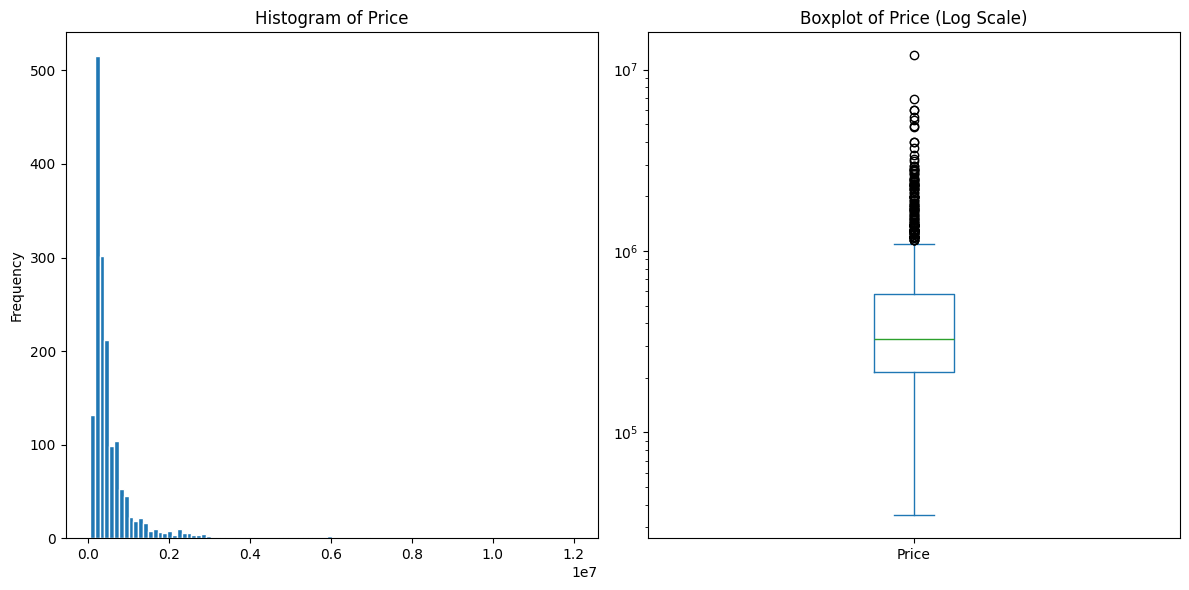

count    1.626000e+03
mean     5.222649e+05
std      6.586958e+05
min      3.500000e+04
25%      2.150000e+05
50%      3.294950e+05
75%      5.800000e+05
max      1.200000e+07
Name: Price, dtype: float64

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram
df.Price.plot(kind='hist', edgecolor='white', bins=100, ax=axs[0])
axs[0].set_title('Histogram of Price')

# Plot boxplot in log scale
df.Price.plot(kind='box', ax=axs[1])
axs[1].set_title('Boxplot of Price (Log Scale)')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

df.Price.describe()

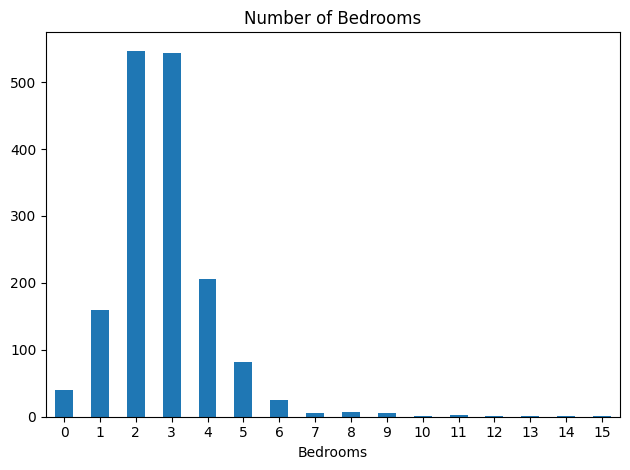

count    1626.000000
mean        2.760148
std         1.417790
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        15.000000
Name: Bedrooms, dtype: float64

In [9]:
# Plot histogram
value_counts = df.Bedrooms.value_counts()
value_counts.index = value_counts.index.astype(int)
value_counts.sort_index().plot(kind='bar')
plt.title('Number of Bedrooms')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

df.Bedrooms.describe()

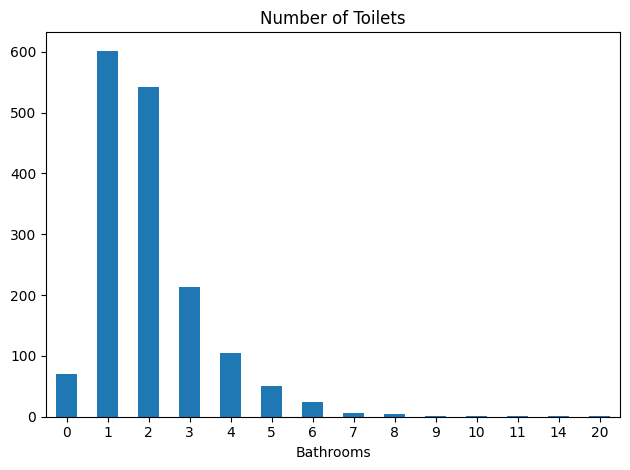

count    1626.000000
mean        2.031365
std         1.448479
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: Bathrooms, dtype: float64

In [10]:
# Plot histogram
value_counts = df.Bathrooms.value_counts()
value_counts.index = value_counts.index.astype(int)
value_counts.sort_index().plot(kind='bar')
plt.title('Number of Toilets')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

df.Bathrooms.describe()

Notice how some properties have no rooms or toilets... These might be just a plot of land! we'll create a new binary feature 'Is_House'

In [11]:
df['Is_House'] = ((df['Bedrooms'] != 0) & (df['Bathrooms'] != 0)).astype(int)

# Lisbon House Price Predictor

In [12]:
# feature engineering

df[['Big_City', 'Small_City']] = df['Address'].str.split(',', n=1, expand=True)
df = df.drop(columns=['Address'])

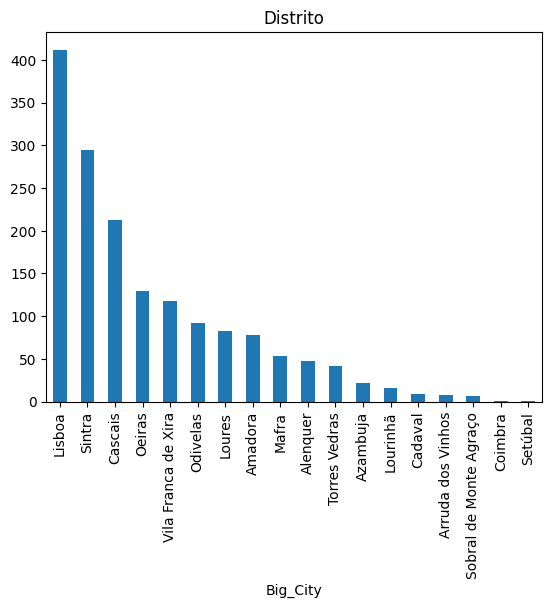

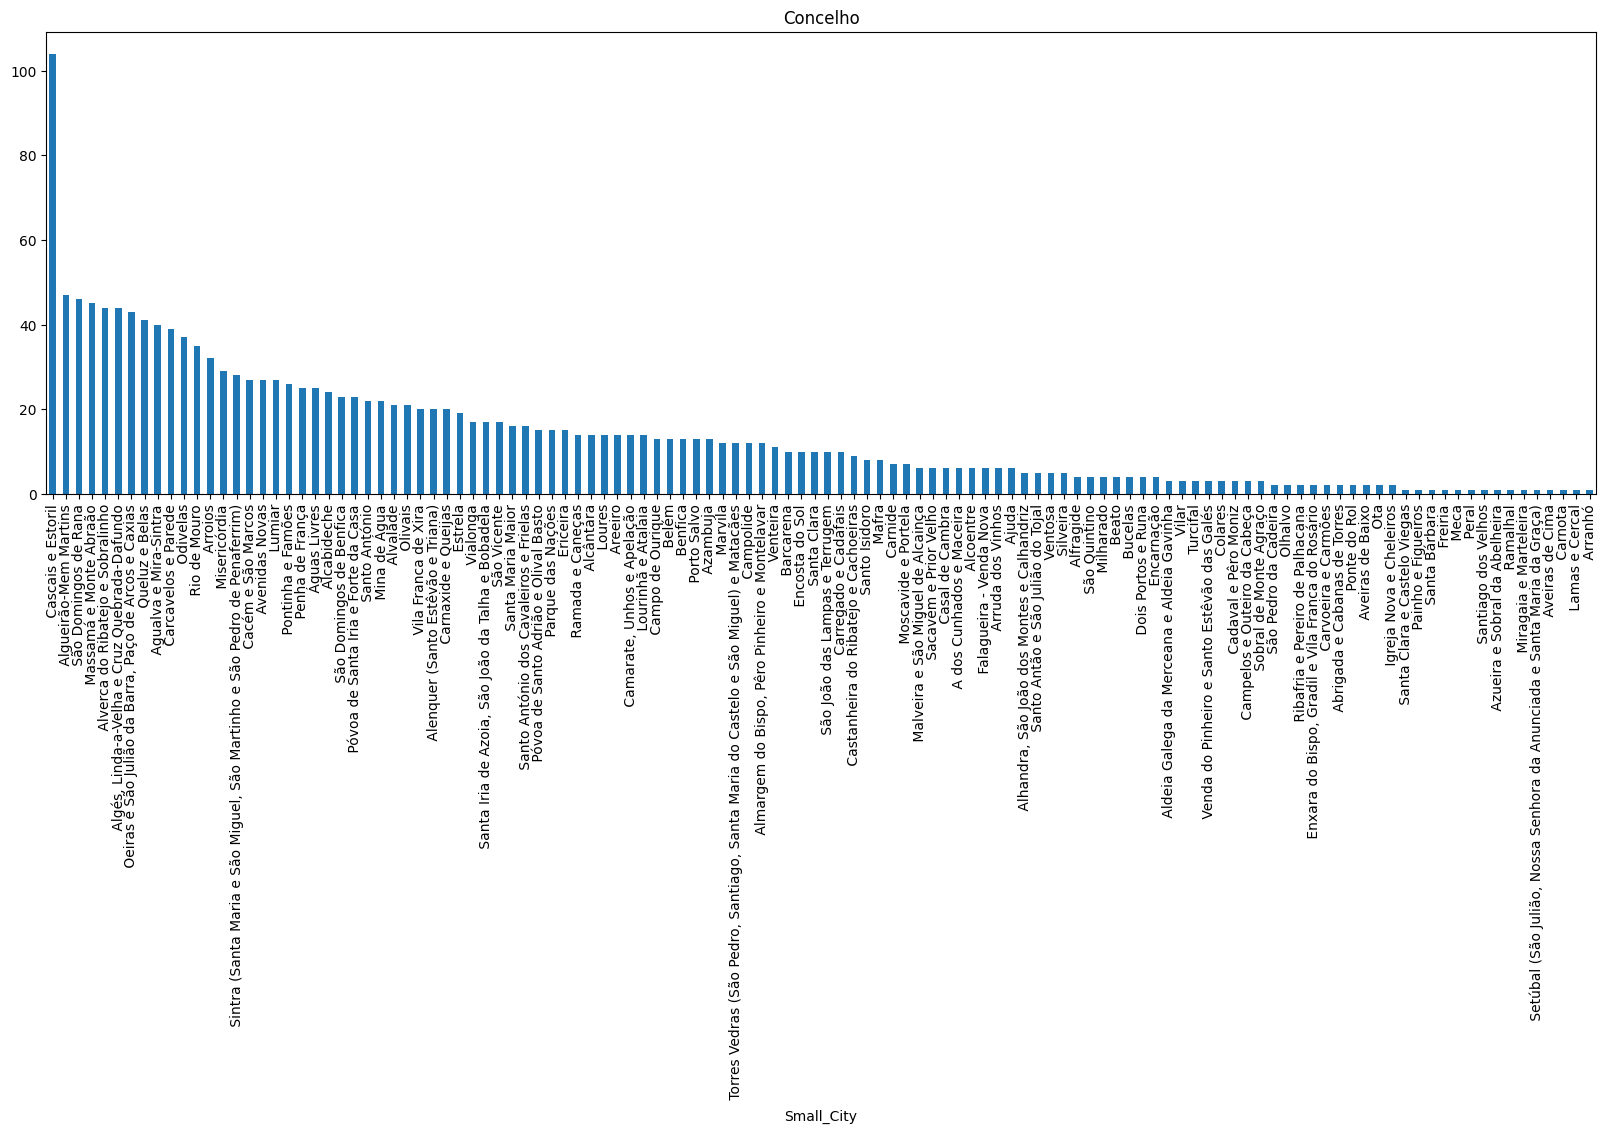

In [13]:
df.Big_City.value_counts().plot(kind='bar')
plt.title('Distrito')
plt.show()

fig = plt.figure(figsize=(20, 6))
df.Small_City.value_counts().plot(kind='bar')
plt.title('Concelho')
plt.show()

## Model Fitting

In [14]:
# target encode categorical variables
target = df['Price']

encoder = ce.TargetEncoder(cols=['Big_City', 'Small_City'])
df[['Big_City', 'Small_City']] = encoder.fit_transform(df[['Big_City', 'Small_City']], target)

In [15]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Price']), df.Price, test_size=0.2)

In [17]:
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a new RandomForestRegressor with the best parameters
rf_best = RandomForestRegressor(**best_params)

# Train the model
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=300)

In [18]:
# Make predictions on the train set
y_pred = rf_best.predict(X_train)

# Calculate the train RMSE
test_rmse = root_mean_squared_error(y_train, y_pred)
print(f'Train Root Mean Squared Error: {test_rmse}')

Train Root Mean Squared Error: 248834.43801401128


In [19]:
# Make predictions on the test set
y_pred = rf_best.predict(X_test)

# Calculate the test RMSE
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test Root Mean Squared Error: {test_rmse}')

Test Root Mean Squared Error: 389900.8187162678


## Model Evaluation

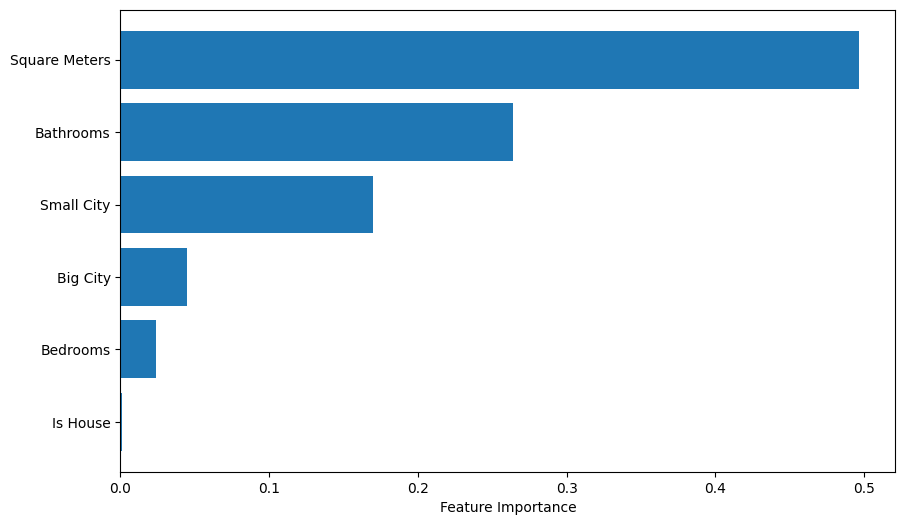

In [21]:
# Get feature importances
importances = rf_best.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'].apply(lambda x: x.replace("_", " ")), feature_importances['importance'], align='center') 
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### Train Set

### Test Set

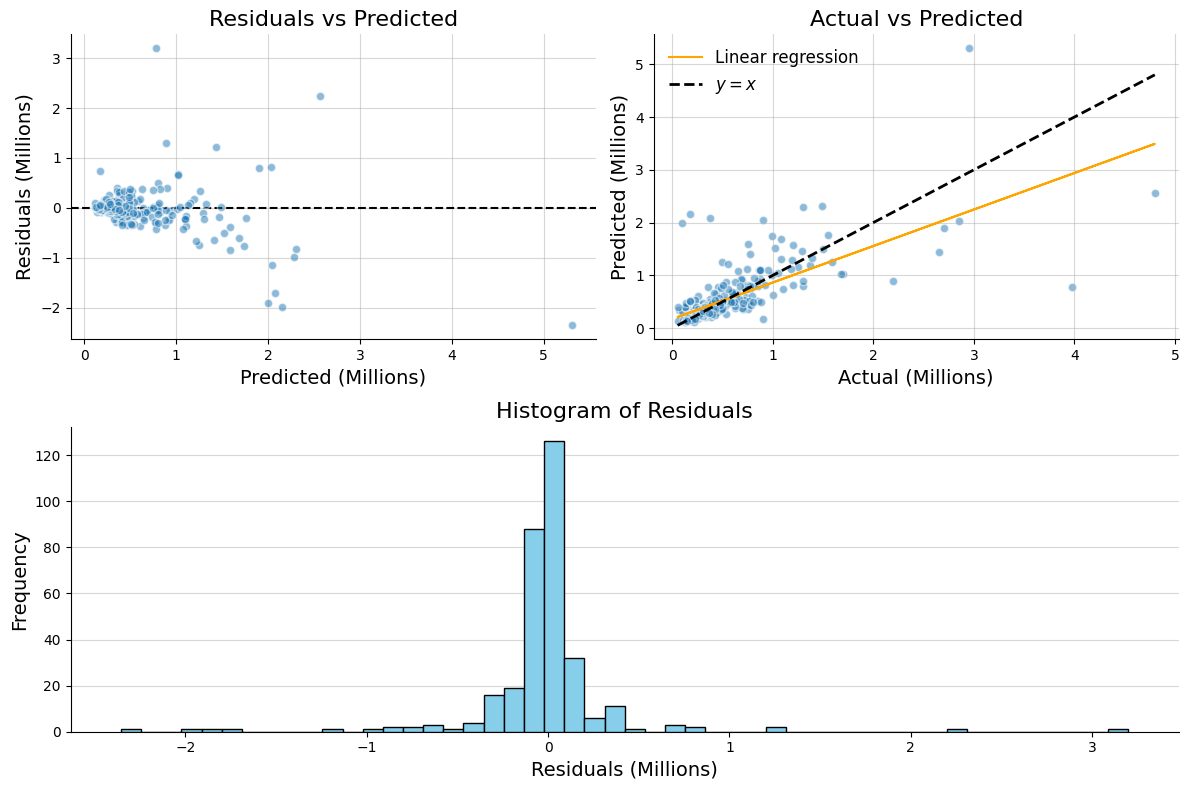

In [22]:
y_pred = rf_best.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Set up the GridSpec layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])

# Define a function to remove top and right spines and add grid
def adjust_plot(ax, grid_horizontal_only=False):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if grid_horizontal_only:
        ax.grid(axis='y', zorder=-1, alpha=0.5)
    else:
        ax.grid(zorder=-1, alpha=0.5)

zorder=10 # so that the grid doesn't sit on top of the datapoints

# First subplot for Residuals vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_pred / 1e6, 
            residuals / 1e6, 
            edgecolor='white', 
            alpha=0.5, 
            zorder=zorder)

ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_xlabel('Predicted (Millions)', fontsize=14)
ax1.set_ylabel('Residuals (Millions)', fontsize=14)
ax1.set_title('Residuals vs Predicted', fontsize=16)
adjust_plot(ax1)

# Second subplot for Actual vs Predicted
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_test / 1e6, 
            y_pred / 1e6, 
            edgecolor='white', 
            alpha=0.5)

lin_reg = LinearRegression()
lin_reg.fit(y_test.values.reshape(-1, 1), y_pred)
y_lin_reg = lin_reg.predict(y_test.values.reshape(-1, 1))

ax2.plot(y_test / 1e6, 
         y_lin_reg / 1e6, 
         color='orange', 
         label='Linear regression')

min_test, max_test = y_test.min() / 1e6, y_test.max() / 1e6
ax2.plot([min_test, max_test], 
         [min_test, max_test], 
         'k--', 
         lw=2, 
         label=r'$y=x$')

ax2.set_xlabel('Actual (Millions)', fontsize=14)
ax2.set_ylabel('Predicted (Millions)', fontsize=14)
ax2.set_title('Actual vs Predicted', fontsize=16)
ax2.legend(fontsize=12, frameon=False)
adjust_plot(ax2)

# Third subplot for Histogram of Residuals spanning both columns
ax3 = fig.add_subplot(gs[1, :])
ax3.hist(residuals / 1e6, 
         bins=50, 
         color='skyblue', 
         edgecolor='black',
         zorder=zorder)

ax3.set_xlabel('Residuals (Millions)', fontsize=14)
ax3.set_ylabel('Frequency', fontsize=14)
ax3.set_title('Histogram of Residuals', fontsize=16)
adjust_plot(ax3, grid_horizontal_only=True)

plt.tight_layout()
plt.show()

### Testing the Model

In [23]:
# the house in question is: https://www.idealista.pt/en/imovel/33301797/
casa_de_oeiras = {'Square Meters': [80],
                  'Bedrooms': [2],
                  'Bathrooms': [1],
                  'Is_House': [1],
                  'Big_City': ['Oeiras'],
                  'Small_City': ['Oeiras e São Julião da Barra, Paço de Arcos e Caxias']}

casa_de_oeiras = pd.DataFrame(casa_de_oeiras)
casa_de_oeiras[['Big_City', 'Small_City']] = encoder.transform(casa_de_oeiras[['Big_City', 'Small_City']])

print(f'Preço do apartamento de Oeiras: {int(rf_best.predict(casa_de_oeiras)[0])}€')

Preço do apartamento de Oeiras: 279750€


In [34]:
!open .